In [1]:
import odl
import numpy as np
import scipy
from skimage import io as skio

import dart_ops as DART_stuff

from matplotlib import pyplot as plt


###############################################################################
# Set up the inverse problem
###############################################################################
# Discrete reconstruction space: discretized functions on the rectangle
# [-20, 20]^2 with 300 samples per dimension.
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], max_pt=[20, 20], shape=[256, 256], dtype="float64"
)

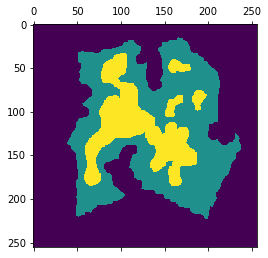

In [2]:
# Make a parallel beam geometry with flat detector
# Angles: uniformly spaced, n = 18, min = 0, max = pi
angle_partition = odl.uniform_partition(0, np.pi, 18)
# Detector: uniformly sampled, n = 450, min = -30, max = 30
detector_partition = odl.uniform_partition(-30, 30, 450)
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)

# Ray transform (= forward projection). We use ASTRA CUDA backend.
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl="astra_cuda")

# Create a phantom
image = np.rot90(
    skio.imread("phantom_3.png"),
    -1,
)
phantom = reco_space.element(image) / 255
plt.matshow(phantom)

In [3]:
# Create edge-detection and threshold operators
thresholds = [0.25, 0.75]
values = [0, 0.5, 1]

threshold_op = DART_stuff.ThresholdOperator(reco_space, thresholds, values)
edge_op = DART_stuff.EdgeDetectOperator(reco_space, diagonal_neighbour=False)

In [4]:
# Initialize convolution operator by Fourier formula
#     conv(f, g) = F^{-1}[F[f] * F[g]]
# Where F[.] is the Fourier transform and the fourier transform of a guassian
# with standard deviation filter_width is another gaussian with width
# 1 / filter_width
filter_width = 1.0  # standard deviation of the Gaussian filter
ft = odl.trafos.FourierTransform(reco_space)
c = filter_width ** 2 / 4.0 ** 2
gaussian = ft.range.element(lambda x: np.exp(-(x[0] ** 2 + x[1] ** 2) * c))
convolution = ft.inverse * gaussian * ft


# Create data
data = ray_trafo(phantom)
data += odl.phantom.white_noise(ray_trafo.range) * np.mean(data) * 0.1

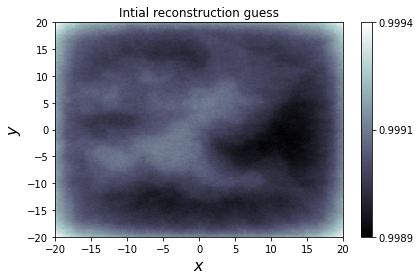

<Figure size 432x288 with 0 Axes>

In [5]:
###############################################################################
# DART-reconstruciton
###############################################################################
# Create a starting guess
x = reco_space.one()
odl.solvers.conjugate_gradient_normal(ray_trafo, x, data, niter=5)
x.show("Intial reconstruction guess");

In [6]:
x_thresholded = threshold_op(x)
x_thresholded.show("Initial thresholded guess")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
len([a.asarray().shape for a in x])

256

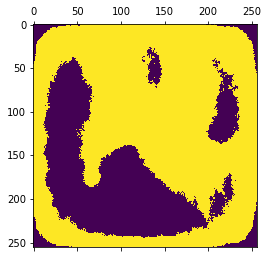

In [35]:
mask = np.less_equal.outer(x.asarray(), [0.9990, 0.9992]).argmax(axis=-1)
plt.matshow(mask)

In [37]:
mask.max()

1